In [298]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [413]:
# user defined functions

# remove the top and bottom 5% of data
def removeExtreme(df, column):
    max_ = df[column].quantile(0.95)
    min_ = df[column].quantile(0.05)
    return df[(df[column] > min_) & (df[column] < max_)]

# create a distribution of bootstrapped sample means 
def bootstrap(df, column, iterations):
    bootstap_mean = []
    for _ in range(iterations):
        data = np.random.choice(df[column], replace = True, size = iterations)
        bootstap_mean.append(np.mean(data))
    return bootstap_mean 

In [657]:
# define parameters 

ticker = 'WMT'
startDate = '2022-10-01'
endDate = '2022-12-31'
dataInterval = '5m'

fastSMA = 20 #9
normalSMA = 100 #50
slowSMA = 200 #200

# moving average period
rollingPeriod = 21

# entry ratio
entryPercentile = 0.10

# exit ratio
exitPercentile = 0.90

In [658]:
# get data
df = yf.download(ticker, startDate, endDate, interval = dataInterval)
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [659]:
# add indicators to dataframe
df['fastSMA'] = df['Close'].rolling(fastSMA).mean()
df['normalSMA'] = df['Close'].rolling(normalSMA).mean()
df['slowSMA'] = df['Close'].rolling(slowSMA).mean()

# drop nulls
df.dropna(inplace=True)
df.reset_index(inplace=True, drop = True)

# If close is higher than slowSMA, then trend in up
df['Trend'] = 'Down'
df.loc[df['Close'] >= df['slowSMA'], 'Trend'] = 'Up'

In [660]:
# calculate the area between slow and fast sma
df['spead_fastSMA_normalSMA'] =  (df['fastSMA'] - df['normalSMA']) / abs(df['Close'] - df['normalSMA'])
df['spead_slowSMA_normalSMA'] =  (df['slowSMA'] - df['normalSMA']) / abs(df['Close'] - df['normalSMA'])

# remove extreme obs
df = removeExtreme(df, 'spead_fastSMA_normalSMA')
df = removeExtreme(df, 'spead_slowSMA_normalSMA')

In [661]:
# define trend 
# slow crossed over fast
df['slowFast_CrossedOver'] = 'Up'
df.loc[df['slowSMA'] >= df['fastSMA'], 'slowFast_CrossedOver'] = 'Down'

# slow crossed over normal
df['slowNormal_CrossedOver'] = 'Up'
df.loc[df['slowSMA'] >= df['normalSMA'], 'slowNormal_CrossedOver'] = 'Down'

# fast crossed over normal
df['fastNormal_CrossedOver'] = 'Up'
df.loc[df['fastSMA'] >= df['normalSMA'], 'fastNormal_CrossedOver'] = 'Down'

# bootstap dataset and calculate sample means
spead_fastSMA_normalSMA_bootstrapped_mean = bootstrap(df, 'spead_fastSMA_normalSMA', 1000)
spead_slowSMA_normalSMA_bootstrapped_mean = bootstrap(df, 'spead_slowSMA_normalSMA', 1000)

# reset index
df.reset_index(inplace=True, drop = True)


In [662]:
df.shape

(2335, 16)

In [663]:
# get the date of when the cross over occured
# create empty placeholder initalized with the first period

try:
    period = [df['Date'][0]]
except KeyError:
    period = [df['Datetime'][0]]

keyDate = []
for i in range(len(df) - 1):
    
    # get current and prior status
    currentStatus = df['fastNormal_CrossedOver'][i+1]
    priorStatus = df['fastNormal_CrossedOver'][i]
    
    # if the status has not changed
    if currentStatus == priorStatus:
        # then set the current period equal to the prior one
        period.append(period[-1])
        keyDate.append(0)
    # if there has been a crossover
    else:
        try:
            period.append(df['Date'][i+1])
        except KeyError:
            period.append(df['Datetime'][i+1])
        keyDate.append(1)
keyDate.append(0)
        
# cross over key date?  
df['Date_fastNormal_CrossedOver_key_Date'] = keyDate
# date when cross over occured    
df['Date_fastNormal_CrossedOver'] = period

In [664]:
# merge df to get the Closing price of crossover date
try:
    data = df[['Date','Close']].copy()
except KeyError:
    data = df[['Datetime','Close']].copy()

data.columns = ['Date_fastNormal_CrossedOver','Close_fastNormal_CrossedOver']
df = df.merge(data, how = 'left', left_on = 'Date_fastNormal_CrossedOver', right_on = 'Date_fastNormal_CrossedOver')

# ROI from when the crossover occured
df['ROI_fastNormal_CrossedOver'] = df['Close'] / df['Close_fastNormal_CrossedOver'] - 1

# ROI if strategy was in place
roi = df.loc[df['Date_fastNormal_CrossedOver_key_Date']==1]

In [665]:
try:
    keyColumns = ['Date_fastNormal_CrossedOver','Date','ROI_fastNormal_CrossedOver',
              'slowFast_CrossedOver','fastNormal_CrossedOver','slowNormal_CrossedOver','Trend']
    roi = roi[keyColumns].copy()

    roi['Days_Spread'] = roi['Date'] - roi['Date_fastNormal_CrossedOver']
    roi['Days_Spread'] = [x.days for x in roi['Days_Spread']]
except KeyError:
    keyColumns = ['Date_fastNormal_CrossedOver','Datetime','ROI_fastNormal_CrossedOver',
              'slowFast_CrossedOver','fastNormal_CrossedOver','slowNormal_CrossedOver','Trend']
    roi = roi[keyColumns].copy()
    roi['Days_Spread'] = roi['Datetime'] - roi['Date_fastNormal_CrossedOver']
    roi['Days_Spread'] = [x.days for x in roi['Days_Spread']]
    



In [666]:
roi_bootstrapped_mean = bootstrap(roi, 'ROI_fastNormal_CrossedOver', 1000)
Days_Spread_bootstrapped_mean = bootstrap(roi, 'Days_Spread', 1000)


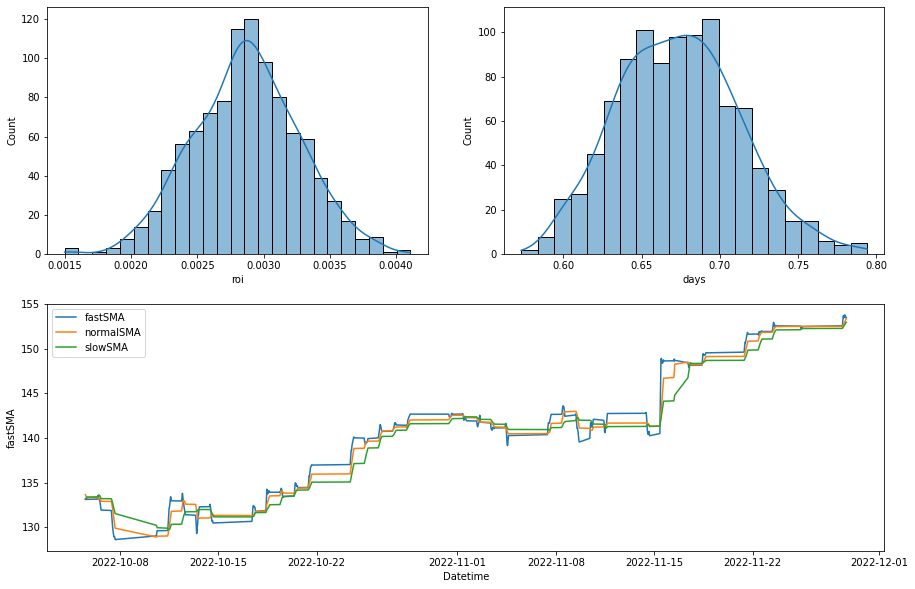

In [667]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.histplot(roi_bootstrapped_mean, kde=True).set(xlabel='roi')

plt.subplot(2,2,2)
sns.histplot(Days_Spread_bootstrapped_mean, kde=True).set(xlabel='days')

plt.subplot(2,1,2)
sns.lineplot(x=df['Datetime'],y=df['fastSMA'], label='fastSMA')
sns.lineplot(x=df['Datetime'],y=df['normalSMA'], label='normalSMA')
sns.lineplot(x=df['Datetime'],y=df['slowSMA'], label='slowSMA')


plt.show()


In [668]:
roi.sort_values('Datetime').tail()

#   Trend Level 1 - Slowest
#         'slowNormal_CrossedOver': 'Slow SMA is ABOVE Normal SMA'
#             -- 'Macro Trend'
#             -- 'Yes': 'Down Trending Long Term Trend'
#             -- 'No': 'Up Trending  Long Term Trend'

#   Trend Level 2 - Normal
#         'Trend': 'Price is ABOVE slow SMA'
#             -- 'Micro Trend'
#             -- 'Up': 'Up Trending Near-Term Trend'
#             -- 'Down': 'Down Trending  Near-Term Trend'

#   Trend Level 3 - Fastest
#         'slowFast_CrossedOver': 'Slow SMA is ABOVE Fast SMA'
#             -- 'Mirco-Mirco Trend'
#             --'Yes': 'Down Trend Micro-Micro Trend'
#             --'No': 'Up Trend Micro-Micro Trend'

#    Entry Signal
#         'fastNormal_CrossedOver': 'Fast SMA is ABOVE Normal SMA'
#             -- 'Entry Signal'
#             -- 'Yes' : 'BUY'
#             -- 'No': 'SELL'

#    Expected ROI
#         'ROI_fastNormal_CrossedOver': 'ROI based on each signal' 
#

roi.rename(columns={'slowNormal_CrossedOver':'Trend-Slow',
                   'Trend':'Trend-Normal',
                   'slowFast_CrossedOver':'Trend-Fast',
                   'fastNormal_CrossedOver':'Signal-Entry-Exit',
                   'ROI_fastNormal_CrossedOver':'Signal-Return',
                   'Days_Spread': 'Signal-Days'}, inplace=True)

In [669]:
roi.groupby(['Trend-Slow','Trend-Normal','Trend-Fast','Signal-Entry-Exit',
             ]).describe()['Signal-Return']

count      mean  \
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                    
Down       Down         Down       Down                 5.0 -0.009356   
                                   Up                   4.0 -0.009077   
                        Up         Down                 1.0 -0.010155   
           Up           Down       Up                   4.0  0.008159   
Up         Down         Up         Down                 4.0 -0.005244   
                                   Up                   1.0  0.000000   
           Up           Down       Up                   1.0  0.052759   
                        Up         Down                11.0  0.007943   
                                   Up                  12.0  0.005404   

                                                           std       min  \
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                       
Down       Down         Down       Down               0.004344 -0.013786   
                                   Up                 0.015691 -0.032061   
                        Up         Down                    NaN -0.010155   
           Up           Down       Up                 0.006274  0.003030   
Up         Down         Up         Down               0.002067 -0.006502   
                                   Up                      NaN  0.000000   
           Up           Down       Up                      NaN  0.052759   
                        Up         Down               0.012149 -0.005919   
                                   Up                 0.004825 -0.000878   

                                                           25%       50%  \
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                       
Down       Down         Down       Down              -0.012013 -0.010617   
                                   Up                -0.012485 -0.003191   
                        Up         Down              -0.010155 -0.010155   
           Up           Down       Up                 0.004499  0.006217   
Up         Down         Up         Down              -0.006440 -0.006151   
                                   Up                 0.000000  0.000000   
           Up           Down       Up                 0.052759  0.052759   
                        Up         Down               0.000000  0.003449   
                                   Up                 0.000614  0.005188   

                                                           75%       max  
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                      
Down       Down         Down       Down              -0.007670 -0.002695  
                                   Up                 0.000216  0.002135  
                        Up         Down              -0.010155 -0.010155  
           Up           Down       Up                 0.009878  0.017172  
Up         Down         Up         Down              -0.004955 -0.002170  
                                   Up                 0.000000  0.000000  
           Up           Down       Up                 0.052759  0.052759  
                        Up         Down               0.014750  0.032875  
                                   Up                 0.009155  0.012944

In [670]:
153.33*1.002336

153.68817888

In [671]:
# Best Long Signal
'Trend-Slow' = 'Up',
'Trend-Normal' = 'Up',
'Trend-Fast' = 'Up',
'Signal-Entry-Exit' = 'Down'

# second Best Long Signal
'Trend-Slow' = 'Up',
'Trend-Normal' = 'Up',
'Trend-Fast' = 'Up',
'Signal-Entry-Exit' = 'Up'



# Best Short Signal
'Trend-Slow' = 'Down',
'Trend-Normal' = 'Down',
'Trend-Fast' = 'Down',
'Signal-Entry-Exit' = 'Up'

# second Best Short Signal
'Trend-Slow' = 'Down',
'Trend-Normal' = 'Down',
'Trend-Fast' = 'Down'
'Signal-Entry-Exit' = 'Down'

SyntaxError: cannot assign to literal (<ipython-input-671-ee0574e8a2a0>, line 2)

In [672]:
df.rename(columns={'slowNormal_CrossedOver':'Trend-Slow',
                   'Trend':'Trend-Normal',
                   'slowFast_CrossedOver':'Trend-Fast',
                   'fastNormal_CrossedOver':'Signal-Entry-Exit',
                   'ROI_fastNormal_CrossedOver':'Signal-Return',
                   'Days_Spread': 'Signal-Days',
                  'Date_fastNormal_CrossedOver_key_Date': 'TradeEvent'}, inplace=True)


In [673]:
# instance where the trade is turned on
trade = df[df['TradeEvent']==1].copy()

# coree columns 
core_df = trade[['Date_fastNormal_CrossedOver','Datetime','Close',
              'Trend-Slow','Trend-Normal','Trend-Fast','Signal-Entry-Exit','TradeEvent']].copy()
core_df.reset_index(inplace=True, drop = True)

# get the max and min close values when trade trigger is turned on
max_high = []
min_low = []
for i in range(len(core_df)):
    data_ = df[(df['Datetime']>=core_df['Date_fastNormal_CrossedOver'][i]) &(df['Datetime']<=core_df['Datetime'][i])]
    max_high.append(data_['High'].max())
    min_low.append(data_['Low'].min())
    
# add to dataframe
core_df['maxHigh'] = max_high
core_df['minLow'] = min_low

# calc the roi
core_df['maxROI'] =  core_df['maxHigh'] - core_df['Close'] 
core_df['minROI'] =  core_df['minLow'] - core_df['Close'] 
core_df['min_max_diff_ROI'] = core_df['maxROI'] + core_df['minROI']

In [674]:
core_df.groupby(['Trend-Slow','Trend-Normal','Trend-Fast','Signal-Entry-Exit',
             ]).describe()[['min_max_diff_ROI','maxROI']]

min_max_diff_ROI  \
                                                                count   
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                    
Down       Down         Down       Down                           5.0   
                                   Up                             4.0   
                        Up         Down                           1.0   
           Up           Down       Up                             4.0   
Up         Down         Up         Down                           4.0   
                                   Up                             1.0   
           Up           Down       Up                             1.0   
                        Up         Down                          11.0   
                                   Up                            12.0   

                                                                          \
                                                          mean       std   
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                       
Down       Down         Down       Down               1.997995  1.004720   
                                   Up                -0.273193  2.945653   
                        Up         Down               2.080002       NaN   
           Up           Down       Up                -1.357201  0.851819   
Up         Down         Up         Down               1.847515  0.655515   
                                   Up                -0.070007       NaN   
           Up           Down       Up                -9.445190       NaN   
                        Up         Down              -0.819556  1.608921   
                                   Up                -0.844719  0.774741   

                                                                          \
                                                           min       25%   
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                       
Down       Down         Down       Down               0.429993  1.564987   
                                   Up                -2.449997 -1.912090   
                        Up         Down               2.080002  2.080002   
           Up           Down       Up                -2.495010 -1.571609   
Up         Down         Up         Down               1.225082  1.363773   
                                   Up                -0.070007 -0.070007   
           Up           Down       Up                -9.445190 -9.445190   
                        Up         Down              -4.204987 -1.557793   
                                   Up                -2.219986 -1.274990   

                                                                          \
                                                           50%       75%   
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                       
Down       Down         Down       Down               2.510010  2.639999   
                                   Up                -1.346390  0.292507   
                        Up         Down               2.080002  2.080002   
           Up           Down       Up                -1.251900 -1.037491   
Up         Down         Up         Down               1.757492  2.241234   
                                   Up                -0.070007 -0.070007   
           Up           Down       Up                -9.445190 -9.445190   
                        Up         Down              -0.254593  0.054993   
                                   Up                -0.931160 -0.051231   

                                                               maxROI  \
                                                           max  count   
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                    
Down       Down         Down       Down               2.844986    5.0   
                                   Up                 4.050003    4.0   
                        Up         Down               2.080002    1.0   

In [676]:
core_df.tail()

,Date_fastNormal_CrossedOver,Datetime,Close,Trend-Slow,Trend-Normal,Trend-Fast,Signal-Entry-Exit,TradeEvent,maxHigh,minLow,maxROI,minROI,min_max_diff_ROI
38,2022-11-17 09:30:00-05:00,2022-11-17 12:45:00-05:00,148.339996,Up,Up,Up,Up,1,148.729996,146.710007,0.389999,-1.629990,-1.239990
39,2022-11-17 12:50:00-05:00,2022-11-17 13:30:00-05:00,148.000000,Down,Down,Down,Down,1,148.529999,147.899994,0.529999,-0.100006,0.429993
40,2022-11-17 14:20:00-05:00,2022-11-18 09:35:00-05:00,149.089996,Down,Up,Down,Up,1,149.899994,147.850006,0.809998,-1.239990,-0.429993
41,2022-11-18 09:40:00-05:00,2022-11-25 09:35:00-05:00,152.339996,Up,Up,Up,Down,1,153.365005,148.940094,1.025009,-3.399902,-2.374893
42,2022-11-25 09:40:00-05:00,2022-11-25 13:00:00-05:00,153.070007,Up,Up,Up,Up,1,153.300003,151.862701,0.229996,-1.207306,-0.977310
